# DSCI Project Proposal – Group 15

## Introduction

Roughly 17.9 million lives are lost each year due to cardiovascular diseases. Heart activity such as heart rate and resting ECG results can be used to detect cardiovascular diseases. For this project, we want to use the dataset “Heart Failure Prediction Dataset” to answer our question:

***"Can we use one's resting ECG and maximum heart rate to accurately predict whether or not a person is at risk of heart disease?"***

This dataset is a combination of independent datasets from hospitals in Hungary, Switzerland, and the United States of America. The dataset in its entirety includes eleven variables that can be used to predict heart disease. However, in our project, we will solely focus on the resting ECG results and the maximum heart rate achieved because we want to know if heart activity alone is an accurate predictor for cardiovascular diseases.

#### *Variables in dataset:*

* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST  elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal] 

## Preliminary Exploratory Data Analysis

#### *Reading the data set:*

In [99]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

set.seed(9999)

In [100]:
heart_data <- read_csv("https://raw.githubusercontent.com/tyih985/DSCI-Project-Attempt-2/main/heart.csv")
glimpse(heart_data)

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 918
Columns: 12
$ Age            <dbl> 40, 49, 37, 48, 54, 39, 45, 54, 37, 48, 37, 58, 39, 49,…
$ Sex            <chr> "M", "F", "M", "F", "M", "M", "F", "M", "M", "F", "F", …
$ ChestPainType  <chr> "ATA", "NAP", "ATA", "ASY", "NAP", "NAP", "ATA", "ATA",…
$ RestingBP      <dbl> 140, 160, 130, 138, 150, 120, 130, 110, 140, 120, 130, …
$ Cholesterol    <dbl> 289, 180, 283, 214, 195, 339, 237, 208, 207, 284, 211, …
$ FastingBS      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ RestingECG     <chr> "Normal", "Normal", "ST", "Normal", "Normal", "Normal",…
$ MaxHR          <dbl> 172, 156, 98, 108, 122, 170, 170, 142, 130, 120, 142, 9…
$ ExerciseAngina <chr> "N", "N", "N", "Y", "N", "N", "N", "N", "Y", "N", "N", …
$ Oldpeak        <dbl> 0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, …
$ ST_Slope       <chr> "Up", "Flat", "Up", "Flat", "Up", "Up", "Up", "Up", "Fl…
$ HeartDisease   <dbl> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1…


#### *Cleaning and wrangling the data set:*

In [101]:
heart_data_cleaned <- heart_data |> rename(resting_ecg = RestingECG, max_hr = MaxHR, heart_disease = HeartDisease) |>
                                    select(resting_ecg, max_hr, heart_disease) |>
                                    mutate(heart_disease = as_factor(heart_disease)) |>
                                    mutate(heart_disease = fct_recode(heart_disease, "yes" = "1", "no" = "0"))
glimpse(heart_data_cleaned)

Rows: 918
Columns: 3
$ resting_ecg   <chr> "Normal", "Normal", "ST", "Normal", "Normal", "Normal", …
$ max_hr        <dbl> 172, 156, 98, 108, 122, 170, 170, 142, 130, 120, 142, 99…
$ heart_disease <fct> no, yes, no, yes, no, no, no, no, yes, no, no, yes, no, …


#### *Summarizing the data set:*

To check if there was a significant class imbalance in our dataset, we counted the number of observations in each class using summarize(). This helped us determine whether or not we would have to rebalance the dataset by oversampling the rarer class.

In [102]:
class_count <- heart_data_cleaned |>
               group_by(heart_disease) |>
               count()
class_count

heart_disease,n
<fct>,<int>
no,410
yes,508


As shown in the table above, there is not a significant class imbalance in this data set, meaning that the K-nearest neighbours algorithm should work properly when we use it on this data set.

Next, we used summarize() to find the mean value of max_hr for those with heart disease, and for those without heart disease. This gave us some more background knowledge and context to use when we answer our predictive question, as it gives us the average values of max_hr for the two classes in our data set.

In [103]:
heart_summary <- heart_data_cleaned |>
    group_by(heart_disease) |>
    summarize(mean_max_hr = mean(max_hr))
heart_summary

heart_disease,mean_max_hr
<fct>,<dbl>
no,148.1512
yes,127.6555


#### *Visualizing the data set:*

To further our preliminary exploratory data analysis, we want to visualize the values of max_hr for each type of resting_ecg. To make our scatterplot easier to understand, we will make the axes and legend human-readable. Furthermore, we will further convey the relationship between resting_ecg and max_hr on our scatterplot by giving each observation a colour and a shape depending on its class 

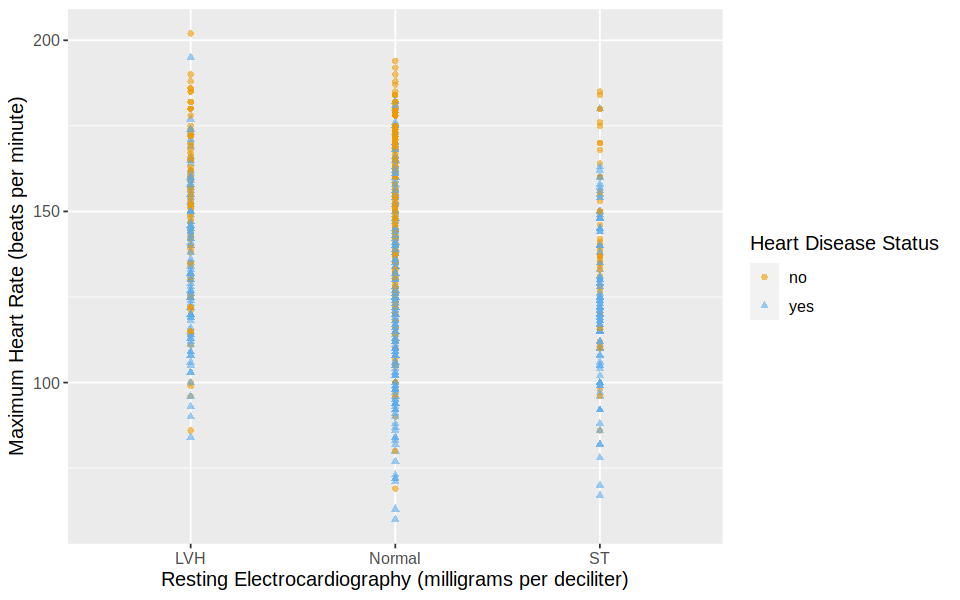

In [104]:
options(repr.plot.width = 8, repr.plot.height = 5)
heart_plot <- ggplot(heart_data_cleaned, aes(x = resting_ecg, y = max_hr,
                                                color = heart_disease, shape = heart_disease)) +
                 geom_point(alpha = 0.6) +
                 
                 labs(x = "Resting Electrocardiography (milligrams per deciliter)", y = "Maximum Heart Rate (beats per minute)",
                      color = "Heart Disease Status", shape = "Heart Disease Status") +
                 scale_color_manual(values = c("orange2", "steelblue2")) +
                 theme(text = element_text(size = 12),
                       legend.position = "right", legend.direction = "vertical")
heart_plot

From the scatterplot above, we can see that there is a turning point on the y-axis between those with heart disease and those without heart disease for each type of resting ECG result. Therefore, if our classification model has the resting_ecg of a new observation, and the value of its max_hr, the model will be able to classify whether or not the observation is at risk of heart disease or not.

## Methods

The values from the selected columns (resting_ecg and max_hr) will be used in our analysis because these variables are directly monitored by heart activity, rather than other variables that are monitored by bodily fluids such as cholesterol. Using these two predictors, we will create a classification model by using K-nearest neighbors algorithm to predict whether a person is at risk of heart disease. To visualize these results, we will use scatter plots and include human readable legends and axes, shapes, and color to distinguish the classes. 

## Expected outcomes and significance:

#### *What do we expect to find?*

words

#### *What impact could such findings have?*

If we find out that a resting bp has an influence on whether or not a person is likely to get a heart disease, we can advise patients and people in general better in terms of training and diet, and thereby prevent them (or make it less likely) from getting a heart disease.

#### *What future questions could this lead to?*

words